In [ ]:
# Model klasyfikacji szans sprzedaży nowo wprowadzanych na rynek produktów.

In [ ]:
# Celem projektu jest zaproponowanie modelu klasyfikacji szans sprzedaży nowo wprowadzanych na rynek produktów. 
# Nowe produkty przydzielone mają zostać do kategorii szacowanej wielkości sprzedaży posiadającej trzy wartości:
# POOR, OK, GOOD. 
# Gdzie POOR oznacza brak szans na dobrą sprzedaż, OK - sprzedaż na przeciętnym poziomie, GOOD - wysoka sprzedaż.
# Klasyfikacja taka pozwoli działowi sprzedaży na dobieranie do oferty produktów najlepiej rokujących. 
# Dane do projektu zostały dobrane pod konkretny kanał dystrybucyjny w konkretnym kraju lecz sam kod
# wykorzystać będzie można ponownie ucząc model na danych właściwych innym kanałom dystrybucji. 

In [ ]:
# Opis danych:
# Dane pochodzą z wewnętrznej bazy produktów. Jest to połączenie tabel:
# 1.Produktów zawierającą klasyfikację produktu(SPGS_CLASS_NAME, SPGS_DEPARTMENT_NAME, SPGS_DIVISION_NAME), 
# informacje o marce produktu, cenie zakupu, cenie sprzedaży, rodzaju opakowania (wielkości), 
# liczebności najmniejszej jednostki klasyfikacji produktu (CLASS_ART_COUNT).
# 2.Bazy sprzedażowej zawierającej wielkości sprzedaży w danym kraju oraz konkretnego klienta, 
# który w tym projekcie jest postrzegany jako osobny kanał dystrybucyjny. Na potrzeby projektu analizuję sprzedaż z 200 dni.
# Do klasyfikacji statusu sprzedaży stworzyłem własne miary, dzięki czemu byłem w stanie zaklasyfikować wielkość sprzedaży jako:
# POOR, OK, GOOD.
# Do analizy posłużą wartości każdego z produktów w bazie danych (aktualnie dostępnego w ofercie), 
# więc każdy z wierszy zawiera informację o poszczególnym produkcie. Z tego też powodu do trningu 
# modelu używać będę całego zbioru danych.

In [1]:
#Ładuję biblioteki.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn import preprocessing

In [2]:
# Wczytaj dane DATA.csv.
filename = 'DATA.csv'
data_location = 'art_condition/'
article_data = pd.read_csv(data_location + filename, sep=',')

In [3]:
# Sprawdzam wczytane dane.
article_data.head()

,PRODUCT_KEY,ARTICLE_CODE,ARTICLE_NAME,EU_BRAND_CODE,EU_BRAND_NAME,SPGS_CLASS_CODE,SPGS_CLASS_NAME,SPGS_DEPARTMENT_CODE,SPGS_DEPARTMENT_NAME,SPGS_DIVISION_CODE,...,VAT_PERCENTAGE,SELLING_UOM_CODE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER,ABOVE_THAN_AVG_country,ARTICLE_SALES_CONDITION
0,20817001,331247,Conferencechair Coral move black/pk4,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,...,21.0,PK,0,33.230769,0,53.923077,13,0,0,POOR
1,29518630,340617,Folding chair black,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,...,21.0,EA,432,33.230769,699,53.923077,13,1,1,GOOD
2,29521051,347665,Meeting chair Isolde black,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,...,21.0,EA,0,33.230769,0,53.923077,13,0,0,POOR
3,23619009,336470,Conferencechair Arcade black/pk4,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,...,21.0,PK,0,33.230769,0,53.923077,13,0,0,POOR
4,31384175,362494,Meeting chair 041 bk KL/chredm,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,...,21.0,EA,0,33.230769,0,53.923077,13,0,0,POOR


In [4]:
# Usuwam zbędne kolumny 'PRODUCT_KEY', 'ARTICLE_CODE' oraz 'ARTICLE_NAME', które są indeksami w badanym zbiorze.
del article_data['PRODUCT_KEY']
del article_data['ARTICLE_CODE']
del article_data['ARTICLE_NAME']

In [5]:
# Ponownie sprawdzam dane.
article_data.head()

,EU_BRAND_CODE,EU_BRAND_NAME,SPGS_CLASS_CODE,SPGS_CLASS_NAME,SPGS_DEPARTMENT_CODE,SPGS_DEPARTMENT_NAME,SPGS_DIVISION_CODE,SPGS_DIVISION_NAME,ARTICLE_TYPE,ARTICLE_TYPE_CODE,...,VAT_PERCENTAGE,SELLING_UOM_CODE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER,ABOVE_THAN_AVG_country,ARTICLE_SALES_CONDITION
0,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,4,...,21.0,PK,0,33.230769,0,53.923077,13,0,0,POOR
1,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,1,...,21.0,EA,432,33.230769,699,53.923077,13,1,1,GOOD
2,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,1,...,21.0,EA,0,33.230769,0,53.923077,13,0,0,POOR
3,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,4,...,21.0,PK,0,33.230769,0,53.923077,13,0,0,POOR
4,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,4,...,21.0,EA,0,33.230769,0,53.923077,13,0,0,POOR


In [6]:
# Sprawdzam strukturę danych. 
article_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21074 entries, 0 to 21073
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   EU_BRAND_CODE                       21074 non-null  int64  
 1   EU_BRAND_NAME                       21074 non-null  object 
 2   SPGS_CLASS_CODE                     21074 non-null  object 
 3   SPGS_CLASS_NAME                     21074 non-null  object 
 4   SPGS_DEPARTMENT_CODE                21074 non-null  object 
 5   SPGS_DEPARTMENT_NAME                21074 non-null  object 
 6   SPGS_DIVISION_CODE                  21074 non-null  int64  
 7   SPGS_DIVISION_NAME                  21074 non-null  object 
 8   ARTICLE_TYPE                        21074 non-null  object 
 9   ARTICLE_TYPE_CODE                   21074 non-null  int64  
 10  ECO_EASY_FLG                        21074 non-null  object 
 11  PRICING_ARTICLE_CATEGORY_CODE       21074

In [7]:
# Część zmiennym jest typu object, więc zmieniamy je na zmienną kategoryczną. W tym momencie zamieniam wszsystkie zmienne,
# dopiero w późniejszych krokach będę zastanawiać się nad ich eliminacją.  

for col in ["EU_BRAND_NAME", "SPGS_CLASS_NAME","SPGS_CLASS_CODE", "SPGS_DEPARTMENT_CODE","SPGS_DEPARTMENT_NAME",
            "SPGS_DIVISION_NAME","ARTICLE_TYPE","ARTICLE_TYPE_CODE","ECO_EASY_FLG", "PRICING_ARTICLE_CATEGORY_NAME",
            "SELLING_UOM_CODE", "ABOVE_THAN_AVG_country"]:
    article_data[col] = article_data[col].astype('category')

In [8]:
# Ponownie sprawdzam strukturę danych. 
article_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21074 entries, 0 to 21073
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   EU_BRAND_CODE                       21074 non-null  int64   
 1   EU_BRAND_NAME                       21074 non-null  category
 2   SPGS_CLASS_CODE                     21074 non-null  category
 3   SPGS_CLASS_NAME                     21074 non-null  category
 4   SPGS_DEPARTMENT_CODE                21074 non-null  category
 5   SPGS_DEPARTMENT_NAME                21074 non-null  category
 6   SPGS_DIVISION_CODE                  21074 non-null  int64   
 7   SPGS_DIVISION_NAME                  21074 non-null  category
 8   ARTICLE_TYPE                        21074 non-null  category
 9   ARTICLE_TYPE_CODE                   21074 non-null  category
 10  ECO_EASY_FLG                        21074 non-null  category
 11  PRICING_ARTICLE_CATEGORY_COD

In [9]:
article_data.shape

(21074, 25)

In [10]:
article_data.head()

,EU_BRAND_CODE,EU_BRAND_NAME,SPGS_CLASS_CODE,SPGS_CLASS_NAME,SPGS_DEPARTMENT_CODE,SPGS_DEPARTMENT_NAME,SPGS_DIVISION_CODE,SPGS_DIVISION_NAME,ARTICLE_TYPE,ARTICLE_TYPE_CODE,...,VAT_PERCENTAGE,SELLING_UOM_CODE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER,ABOVE_THAN_AVG_country,ARTICLE_SALES_CONDITION
0,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,4,...,21.0,PK,0,33.230769,0,53.923077,13,0,0,POOR
1,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,1,...,21.0,EA,432,33.230769,699,53.923077,13,1,1,GOOD
2,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,1,...,21.0,EA,0,33.230769,0,53.923077,13,0,0,POOR
3,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,4,...,21.0,PK,0,33.230769,0,53.923077,13,0,0,POOR
4,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,4,...,21.0,EA,0,33.230769,0,53.923077,13,0,0,POOR


In [11]:
# Wyświetlam nagłówki kolumn, które będę wykorzystywać w kolejnych korkach.
print(article_data.columns.str.cat(sep=", "))

EU_BRAND_CODE, EU_BRAND_NAME, SPGS_CLASS_CODE, SPGS_CLASS_NAME, SPGS_DEPARTMENT_CODE, SPGS_DEPARTMENT_NAME, SPGS_DIVISION_CODE, SPGS_DIVISION_NAME, ARTICLE_TYPE, ARTICLE_TYPE_CODE, ECO_EASY_FLG, PRICING_ARTICLE_CATEGORY_CODE, PRICING_ARTICLE_CATEGORY_NAME, ACTUAL_PURCHASE_PRICE_EUR_AMT, CATALOGUE_SALES_PRICE_EUR_AMT, VAT_PERCENTAGE, SELLING_UOM_CODE, SPECIFIC_CUSTOMER_SALES, SPECIFIC_CUSTOMER_CLASS_SALES_MEAN, COUNTRY_SALES, COUNTRY_SALES_CLASS_MEAN, CLASS_ART_COUNT, ABOVE_THAN_AVG_CUSTOMER, ABOVE_THAN_AVG_country, ARTICLE_SALES_CONDITION


In [12]:
# Dla lepszej czytelności zmieniam pozycję zmiennej objaśnianej 'ARTICLE_SALES_CONDITION' na pierwsze miejsce.
print(article_data.columns.values)
article_data = article_data[['ARTICLE_SALES_CONDITION','EU_BRAND_CODE', 'EU_BRAND_NAME', 'SPGS_CLASS_CODE', 'SPGS_CLASS_NAME',
 'SPGS_DEPARTMENT_CODE', 'SPGS_DEPARTMENT_NAME' ,'SPGS_DIVISION_CODE',
 'SPGS_DIVISION_NAME', 'ARTICLE_TYPE', 'ARTICLE_TYPE_CODE' ,'ECO_EASY_FLG',
 'PRICING_ARTICLE_CATEGORY_CODE', 'PRICING_ARTICLE_CATEGORY_NAME',
 'ACTUAL_PURCHASE_PRICE_EUR_AMT', 'CATALOGUE_SALES_PRICE_EUR_AMT',
 'VAT_PERCENTAGE', 'SELLING_UOM_CODE', 'SPECIFIC_CUSTOMER_SALES',
 'SPECIFIC_CUSTOMER_CLASS_SALES_MEAN', 'COUNTRY_SALES',
 'COUNTRY_SALES_CLASS_MEAN', 'CLASS_ART_COUNT', 'ABOVE_THAN_AVG_CUSTOMER',
 'ABOVE_THAN_AVG_country']]

['EU_BRAND_CODE' 'EU_BRAND_NAME' 'SPGS_CLASS_CODE' 'SPGS_CLASS_NAME'
 'SPGS_DEPARTMENT_CODE' 'SPGS_DEPARTMENT_NAME' 'SPGS_DIVISION_CODE'
 'SPGS_DIVISION_NAME' 'ARTICLE_TYPE' 'ARTICLE_TYPE_CODE' 'ECO_EASY_FLG'
 'PRICING_ARTICLE_CATEGORY_CODE' 'PRICING_ARTICLE_CATEGORY_NAME'
 'ACTUAL_PURCHASE_PRICE_EUR_AMT' 'CATALOGUE_SALES_PRICE_EUR_AMT'
 'VAT_PERCENTAGE' 'SELLING_UOM_CODE' 'SPECIFIC_CUSTOMER_SALES'
 'SPECIFIC_CUSTOMER_CLASS_SALES_MEAN' 'COUNTRY_SALES'
 'COUNTRY_SALES_CLASS_MEAN' 'CLASS_ART_COUNT' 'ABOVE_THAN_AVG_CUSTOMER'
 'ABOVE_THAN_AVG_country' 'ARTICLE_SALES_CONDITION']


In [13]:
# Sprawdzam rozkład zmiennej objaśnianej.
article_data["ARTICLE_SALES_CONDITION"].value_counts()

POOR    14554
OK       5161
GOOD     1359
Name: ARTICLE_SALES_CONDITION, dtype: int64

In [14]:
# Sprawdzam występowanie wartości nan
article_data.isnull().values.any()

True

In [15]:
# Sprawdzam ilość wartości
article_data.isnull().sum().sum()

102

In [16]:
# Usuwam wiersze z wartościami nan. Zbiór jest duży, więc można poświęcić 102 obserwacji.
article_data = article_data.dropna()
# Resetuję index.
article_data.reset_index(drop=True)


,ARTICLE_SALES_CONDITION,EU_BRAND_CODE,EU_BRAND_NAME,SPGS_CLASS_CODE,SPGS_CLASS_NAME,SPGS_DEPARTMENT_CODE,SPGS_DEPARTMENT_NAME,SPGS_DIVISION_CODE,SPGS_DIVISION_NAME,ARTICLE_TYPE,...,CATALOGUE_SALES_PRICE_EUR_AMT,VAT_PERCENTAGE,SELLING_UOM_CODE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER,ABOVE_THAN_AVG_country
0,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,345.45,21.0,PK,0,33.230769,0,53.923077,13,0,0
1,GOOD,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,15.00,21.0,EA,432,33.230769,699,53.923077,13,1,1
2,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,35.00,21.0,EA,0,33.230769,0,53.923077,13,0,0
3,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,363.27,21.0,PK,0,33.230769,0,53.923077,13,0,0
4,POOR,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,299.00,21.0,EA,0,33.230769,0,53.923077,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21001,GOOD,656,Microsoft,8-87-458,Unassigned Installation & Warr,8-87,Tech Services,8,Tech Services & Warranties,OEM Brand,...,149.41,21.0,EA,0,0.000000,0,0.000000,2,1,1
21002,GOOD,584,HP,8-87-458,Unassigned Installation & Warr,8-87,Tech Services,8,Tech Services & Warranties,OEM Brand,...,112.37,21.0,EA,0,0.000000,0,0.000000,2,1,1
21003,OK,3612,EasyTech,8-87-819,Ordered Parts,8-87,Tech Services,8,Tech Services & Warranties,Internal,...,3.72,21.0,EA,0,0.000000,0,37.000000,2,1,0
21004,GOOD,3612,EasyTech,8-87-819,Ordered Parts,8-87,Tech Services,8,Tech Services & Warranties,Internal,...,4.96,21.0,EA,0,0.000000,74,37.000000,2,1,1


In [17]:
# Sprawdza podstawowe statystyki zbioru. 
article_data.describe()

,EU_BRAND_CODE,SPGS_DIVISION_CODE,PRICING_ARTICLE_CATEGORY_CODE,ACTUAL_PURCHASE_PRICE_EUR_AMT,CATALOGUE_SALES_PRICE_EUR_AMT,VAT_PERCENTAGE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER
count,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000,21006.000000
mean,1584.656670,4.142959,5004.419975,72.905194,142.056116,20.550557,1.052271,1.050164,156.166238,155.923144,451.867466,0.188137
std,1607.278816,2.029627,2.660591,343.251788,795.845428,2.365686,10.276280,2.430514,1059.353658,283.334181,573.394132,0.390831
min,422.000000,1.000000,5000.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,606.000000,2.000000,5002.000000,5.700000,18.417500,21.000000,0.000000,0.020833,0.000000,10.879857,66.000000,0.000000
50%,1128.000000,5.000000,5004.000000,16.030000,49.000000,21.000000,0.000000,0.470629,3.000000,35.113208,156.000000,0.000000
75%,1486.000000,5.000000,5007.000000,58.000000,139.500000,21.000000,0.000000,1.190000,48.000000,184.858974,1064.000000,0.000000
max,8384.000000,8.000000,5011.000000,21664.799900,62799.000000,21.000000,556.000000,52.600000,86489.000000,4409.363636,1673.000000,1.000000


In [18]:
# Zmienna "CATALOGUE_SALES_PRICE_EUR_AMT" posiada skrajne wartości. 
# Jako właściciel danych wiem, że ceny sprzedaży równe 0.01 są błędne. Eliminuję również ceny sprzedaży powyżej 10,000
# ponieważ są to skrajne i sporadyczne przypadki, które mogą negatywnie wpłynąć na model.

# Warości > 10000 zamieniam na nan.
mask = article_data["CATALOGUE_SALES_PRICE_EUR_AMT"] > 10000
article_data.loc[mask,"CATALOGUE_SALES_PRICE_EUR_AMT"] = np.nan


In [19]:
# Warości = 0.01 zamieniam na nan.
mask = article_data["CATALOGUE_SALES_PRICE_EUR_AMT"] ==  0.01
article_data.loc[mask,"CATALOGUE_SALES_PRICE_EUR_AMT"] = np.nan

In [20]:
# Ponownie usuwam wiersze z wartościami nan. Zbiór jest duży, więc można poświęcić 102 obserwacji.
article_data = article_data.dropna()
# Resetuję index.
article_data.reset_index(drop=True)


,ARTICLE_SALES_CONDITION,EU_BRAND_CODE,EU_BRAND_NAME,SPGS_CLASS_CODE,SPGS_CLASS_NAME,SPGS_DEPARTMENT_CODE,SPGS_DEPARTMENT_NAME,SPGS_DIVISION_CODE,SPGS_DIVISION_NAME,ARTICLE_TYPE,...,CATALOGUE_SALES_PRICE_EUR_AMT,VAT_PERCENTAGE,SELLING_UOM_CODE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER,ABOVE_THAN_AVG_country
0,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,345.45,21.0,PK,0,33.230769,0,53.923077,13,0,0
1,GOOD,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,15.00,21.0,EA,432,33.230769,699,53.923077,13,1,1
2,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,35.00,21.0,EA,0,33.230769,0,53.923077,13,0,0
3,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,363.27,21.0,PK,0,33.230769,0,53.923077,13,0,0
4,POOR,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,299.00,21.0,EA,0,33.230769,0,53.923077,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,GOOD,656,Microsoft,8-87-458,Unassigned Installation & Warr,8-87,Tech Services,8,Tech Services & Warranties,OEM Brand,...,149.41,21.0,EA,0,0.000000,0,0.000000,2,1,1
20996,GOOD,584,HP,8-87-458,Unassigned Installation & Warr,8-87,Tech Services,8,Tech Services & Warranties,OEM Brand,...,112.37,21.0,EA,0,0.000000,0,0.000000,2,1,1
20997,OK,3612,EasyTech,8-87-819,Ordered Parts,8-87,Tech Services,8,Tech Services & Warranties,Internal,...,3.72,21.0,EA,0,0.000000,0,37.000000,2,1,0
20998,GOOD,3612,EasyTech,8-87-819,Ordered Parts,8-87,Tech Services,8,Tech Services & Warranties,Internal,...,4.96,21.0,EA,0,0.000000,74,37.000000,2,1,1


In [21]:
# Ponownie sprawdza podstawowe statystyki zbioru. 
article_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 21073
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ARTICLE_SALES_CONDITION             21000 non-null  object  
 1   EU_BRAND_CODE                       21000 non-null  int64   
 2   EU_BRAND_NAME                       21000 non-null  category
 3   SPGS_CLASS_CODE                     21000 non-null  category
 4   SPGS_CLASS_NAME                     21000 non-null  category
 5   SPGS_DEPARTMENT_CODE                21000 non-null  category
 6   SPGS_DEPARTMENT_NAME                21000 non-null  category
 7   SPGS_DIVISION_CODE                  21000 non-null  int64   
 8   SPGS_DIVISION_NAME                  21000 non-null  category
 9   ARTICLE_TYPE                        21000 non-null  category
 10  ARTICLE_TYPE_CODE                   21000 non-null  category
 11  ECO_EASY_FLG                

In [22]:
# Standaryzuję zmienne liczbowe. Tworzę scaler.
scaler = preprocessing.StandardScaler()

# Tworzę nowy zbiór/kopię pod standaryzację.
article_data_std = article_data

# Dokonuję standaryzacji wybranych zmiennych.
article_data_std[['ACTUAL_PURCHASE_PRICE_EUR_AMT','CATALOGUE_SALES_PRICE_EUR_AMT',
                  'VAT_PERCENTAGE','SPECIFIC_CUSTOMER_CLASS_SALES_MEAN','COUNTRY_SALES_CLASS_MEAN', 
                  'CLASS_ART_COUNT']] = scaler.fit_transform(article_data_std[['ACTUAL_PURCHASE_PRICE_EUR_AMT',
                'CATALOGUE_SALES_PRICE_EUR_AMT','VAT_PERCENTAGE','SPECIFIC_CUSTOMER_CLASS_SALES_MEAN','COUNTRY_SALES_CLASS_MEAN', 'CLASS_ART_COUNT']])


In [23]:
# Sprawdzam jak wyglądają dane po standaryzacji.
article_data_std.head()

,ARTICLE_SALES_CONDITION,EU_BRAND_CODE,EU_BRAND_NAME,SPGS_CLASS_CODE,SPGS_CLASS_NAME,SPGS_DEPARTMENT_CODE,SPGS_DEPARTMENT_NAME,SPGS_DIVISION_CODE,SPGS_DIVISION_NAME,ARTICLE_TYPE,...,CATALOGUE_SALES_PRICE_EUR_AMT,VAT_PERCENTAGE,SELLING_UOM_CODE,SPECIFIC_CUSTOMER_SALES,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT,ABOVE_THAN_AVG_CUSTOMER,ABOVE_THAN_AVG_country
0,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,0.767854,0.190017,PK,0,13.240334,0,-0.359838,-0.765532,0,0
1,GOOD,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,-0.417505,0.190017,EA,432,13.240334,699,-0.359838,-0.765532,1,1
2,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,-0.345763,0.190017,EA,0,13.240334,0,-0.359838,-0.765532,0,0
3,POOR,2033,[Generic Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,0.831777,0.190017,PK,0,13.240334,0,-0.359838,-0.765532,0,0
4,POOR,1369,[BNL Brands],1-10-100,Folding & Stacking Chairs,1-10,Chairs,1,Furniture,OEM Brand,...,0.601233,0.190017,EA,0,13.240334,0,-0.359838,-0.765532,0,0


In [24]:
# Ze zbioru usuwam kolejne zmienne oraz powielające się pary zmiennych kategorycznych (np."EU_BRAND_CODE" = "EU_BRAND_NAME")

article_data_cleaned = article_data_std[['ARTICLE_SALES_CONDITION','EU_BRAND_NAME', 'SPGS_DIVISION_NAME','SPGS_DEPARTMENT_NAME',
                                    'SPGS_CLASS_NAME', 'ARTICLE_TYPE','ECO_EASY_FLG', 'SELLING_UOM_CODE', 'ACTUAL_PURCHASE_PRICE_EUR_AMT',
                                    'CATALOGUE_SALES_PRICE_EUR_AMT','SPECIFIC_CUSTOMER_CLASS_SALES_MEAN',
                                    'COUNTRY_SALES_CLASS_MEAN','CLASS_ART_COUNT']]


In [25]:
article_data_labled = article_data_cleaned

# Zamieniam zmienną opisową:
article_data_labled['ARTICLE_SALES_CONDITION'] = article_data_labled['ARTICLE_SALES_CONDITION'].replace(['POOR','OK','GOOD'],['0','1','2'])
article_data_labled['ARTICLE_SALES_CONDITION'] = article_data_labled['ARTICLE_SALES_CONDITION'].astype(str).astype(int)
article_data_labled["ARTICLE_SALES_CONDITION"].value_counts()

<ipython-input-25-354c47ebfc56>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data_labled['ARTICLE_SALES_CONDITION'] = article_data_labled['ARTICLE_SALES_CONDITION'].replace(['POOR','OK','GOOD'],['0','1','2'])
<ipython-input-25-354c47ebfc56>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data_labled['ARTICLE_SALES_CONDITION'] = article_data_labled['ARTICLE_SALES_CONDITION'].astype(str).astype(int)


0    14490
1     5157
2     1353
Name: ARTICLE_SALES_CONDITION, dtype: int64

In [26]:
# Zamieniam zmienne kategorycnze na zmienne liczbowe za pomocą LabelEncoder.
article_data_labled['EU_BRAND_NAME']= article_data_labled['EU_BRAND_NAME'].cat.codes
article_data_labled['SPGS_DIVISION_NAME'] = article_data_labled['SPGS_DIVISION_NAME'].cat.codes
article_data_labled['SPGS_DEPARTMENT_NAME']= article_data_labled['SPGS_DEPARTMENT_NAME'].cat.codes
article_data_labled['SPGS_CLASS_NAME'] = article_data_labled['SPGS_CLASS_NAME'].cat.codes
article_data_labled['ARTICLE_TYPE'] = article_data_labled['ARTICLE_TYPE'].cat.codes
article_data_labled['ECO_EASY_FLG'] = article_data_labled['ECO_EASY_FLG'].cat.codes
article_data_labled['SELLING_UOM_CODE'] = article_data_labled['SELLING_UOM_CODE'].cat.codes

<ipython-input-26-839113686329>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data_labled['EU_BRAND_NAME']= article_data_labled['EU_BRAND_NAME'].cat.codes
<ipython-input-26-839113686329>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data_labled['SPGS_DIVISION_NAME'] = article_data_labled['SPGS_DIVISION_NAME'].cat.codes
<ipython-input-26-839113686329>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [27]:
# Sprawdzam strukturę danych.
article_data_labled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 21073
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ARTICLE_SALES_CONDITION             21000 non-null  int32  
 1   EU_BRAND_NAME                       21000 non-null  int16  
 2   SPGS_DIVISION_NAME                  21000 non-null  int8   
 3   SPGS_DEPARTMENT_NAME                21000 non-null  int8   
 4   SPGS_CLASS_NAME                     21000 non-null  int16  
 5   ARTICLE_TYPE                        21000 non-null  int8   
 6   ECO_EASY_FLG                        21000 non-null  int8   
 7   SELLING_UOM_CODE                    21000 non-null  int8   
 8   ACTUAL_PURCHASE_PRICE_EUR_AMT       21000 non-null  float64
 9   CATALOGUE_SALES_PRICE_EUR_AMT       21000 non-null  float64
 10  SPECIFIC_CUSTOMER_CLASS_SALES_MEAN  21000 non-null  float64
 11  COUNTRY_SALES_CLASS_MEAN            21000

In [28]:
# Sprawdzam jak wyglądają dane po zamianie zmiennych kategorycznych.
article_data_labled.head()

,ARTICLE_SALES_CONDITION,EU_BRAND_NAME,SPGS_DIVISION_NAME,SPGS_DEPARTMENT_NAME,SPGS_CLASS_NAME,ARTICLE_TYPE,ECO_EASY_FLG,SELLING_UOM_CODE,ACTUAL_PURCHASE_PRICE_EUR_AMT,CATALOGUE_SALES_PRICE_EUR_AMT,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT
0,0,526,2,12,134,1,0,8,0.574691,0.767854,13.240334,-0.359838,-0.765532
1,2,522,2,12,134,1,0,6,-0.300308,-0.417505,13.240334,-0.359838,-0.765532
2,0,526,2,12,134,1,0,6,-0.243397,-0.345763,13.240334,-0.359838,-0.765532
3,0,526,2,12,134,1,0,8,0.621167,0.831777,13.240334,-0.359838,-0.765532
4,0,522,2,12,134,1,0,6,0.474813,0.601233,13.240334,-0.359838,-0.765532


In [29]:
# Tworzę wektor kolumnowy zmiennej objaśnianej
#y = article_data_labled.iloc[:, 0]
y = article_data_labled['ARTICLE_SALES_CONDITION']
y.head()

0    0
1    2
2    0
3    0
4    0
Name: ARTICLE_SALES_CONDITION, dtype: int32

In [30]:
# Tworzę macierze zmiennych objaśniających (predyktorów).
X = article_data_labled.iloc[:, 1:]
X.head()

,EU_BRAND_NAME,SPGS_DIVISION_NAME,SPGS_DEPARTMENT_NAME,SPGS_CLASS_NAME,ARTICLE_TYPE,ECO_EASY_FLG,SELLING_UOM_CODE,ACTUAL_PURCHASE_PRICE_EUR_AMT,CATALOGUE_SALES_PRICE_EUR_AMT,SPECIFIC_CUSTOMER_CLASS_SALES_MEAN,COUNTRY_SALES_CLASS_MEAN,CLASS_ART_COUNT
0,526,2,12,134,1,0,8,0.574691,0.767854,13.240334,-0.359838,-0.765532
1,522,2,12,134,1,0,6,-0.300308,-0.417505,13.240334,-0.359838,-0.765532
2,526,2,12,134,1,0,6,-0.243397,-0.345763,13.240334,-0.359838,-0.765532
3,526,2,12,134,1,0,8,0.621167,0.831777,13.240334,-0.359838,-0.765532
4,522,2,12,134,1,0,6,0.474813,0.601233,13.240334,-0.359838,-0.765532


In [31]:
# Obliczm wspóczynnik korelacji liniowej Pearsona
corr_P = article_data_labled.corr("pearson")
corr_P.shape

(13, 13)

In [32]:
# Tworzę macierz trójkątną i wyświetlamy wspóczynnik korelacji większy od 0.5
corr_P_tri = corr_P.where(np.triu(np.ones(corr_P.shape, dtype=np.bool), k=1)).stack().sort_values()
corr_P_tri

SPGS_DIVISION_NAME                  CLASS_ART_COUNT                 -0.423003
COUNTRY_SALES_CLASS_MEAN            CLASS_ART_COUNT                 -0.297561
ARTICLE_SALES_CONDITION             CLASS_ART_COUNT                 -0.255879
SPGS_DIVISION_NAME                  CATALOGUE_SALES_PRICE_EUR_AMT   -0.239169
SPECIFIC_CUSTOMER_CLASS_SALES_MEAN  CLASS_ART_COUNT                 -0.199009
                                                                       ...   
ARTICLE_TYPE                        COUNTRY_SALES_CLASS_MEAN         0.237483
EU_BRAND_NAME                       ARTICLE_TYPE                     0.240390
SPGS_DIVISION_NAME                  ECO_EASY_FLG                     0.246855
                                    COUNTRY_SALES_CLASS_MEAN         0.330742
ACTUAL_PURCHASE_PRICE_EUR_AMT       CATALOGUE_SALES_PRICE_EUR_AMT    0.953800
Length: 78, dtype: float64

In [33]:
# Wyświetlamy wspóczynnik korelacji większy od 0.5. 
# Z oczywistych względów największy współczynnik korelacji posiada para "ACTUAL_PURCHASE_PRICE_EUR_AMT"/"CATALOGUE_SALES_PRICE_EUR_AMT"
corr_P_tri[abs(corr_P_tri)>0.5]

ACTUAL_PURCHASE_PRICE_EUR_AMT  CATALOGUE_SALES_PRICE_EUR_AMT    0.9538
dtype: float64

In [34]:
# Obliczm wspóczynnik korelacji liniowej Spearmana
corr_S = article_data_labled.corr("spearman")
corr_S.shape

(13, 13)

In [35]:
corr_S_tri = corr_S.where(np.triu(np.ones(corr_S.shape, dtype=np.bool), k=1)).stack().sort_values()
corr_S_tri

ACTUAL_PURCHASE_PRICE_EUR_AMT       COUNTRY_SALES_CLASS_MEAN             -0.631144
CATALOGUE_SALES_PRICE_EUR_AMT       COUNTRY_SALES_CLASS_MEAN             -0.553380
SPGS_DIVISION_NAME                  CATALOGUE_SALES_PRICE_EUR_AMT        -0.460206
                                    ACTUAL_PURCHASE_PRICE_EUR_AMT        -0.434386
ACTUAL_PURCHASE_PRICE_EUR_AMT       SPECIFIC_CUSTOMER_CLASS_SALES_MEAN   -0.420271
                                                                            ...   
ECO_EASY_FLG                        COUNTRY_SALES_CLASS_MEAN              0.299773
SPGS_DIVISION_NAME                  SPECIFIC_CUSTOMER_CLASS_SALES_MEAN    0.348056
                                    COUNTRY_SALES_CLASS_MEAN              0.531882
SPECIFIC_CUSTOMER_CLASS_SALES_MEAN  COUNTRY_SALES_CLASS_MEAN              0.648372
ACTUAL_PURCHASE_PRICE_EUR_AMT       CATALOGUE_SALES_PRICE_EUR_AMT         0.932271
Length: 78, dtype: float64

In [36]:
# Wyświetlamy wspóczynnik korelacji większy od 0.5
corr_S_tri[abs(corr_S_tri)>0.5]

ACTUAL_PURCHASE_PRICE_EUR_AMT       COUNTRY_SALES_CLASS_MEAN        -0.631144
CATALOGUE_SALES_PRICE_EUR_AMT       COUNTRY_SALES_CLASS_MEAN        -0.553380
SPGS_DIVISION_NAME                  COUNTRY_SALES_CLASS_MEAN         0.531882
SPECIFIC_CUSTOMER_CLASS_SALES_MEAN  COUNTRY_SALES_CLASS_MEAN         0.648372
ACTUAL_PURCHASE_PRICE_EUR_AMT       CATALOGUE_SALES_PRICE_EUR_AMT    0.932271
dtype: float64

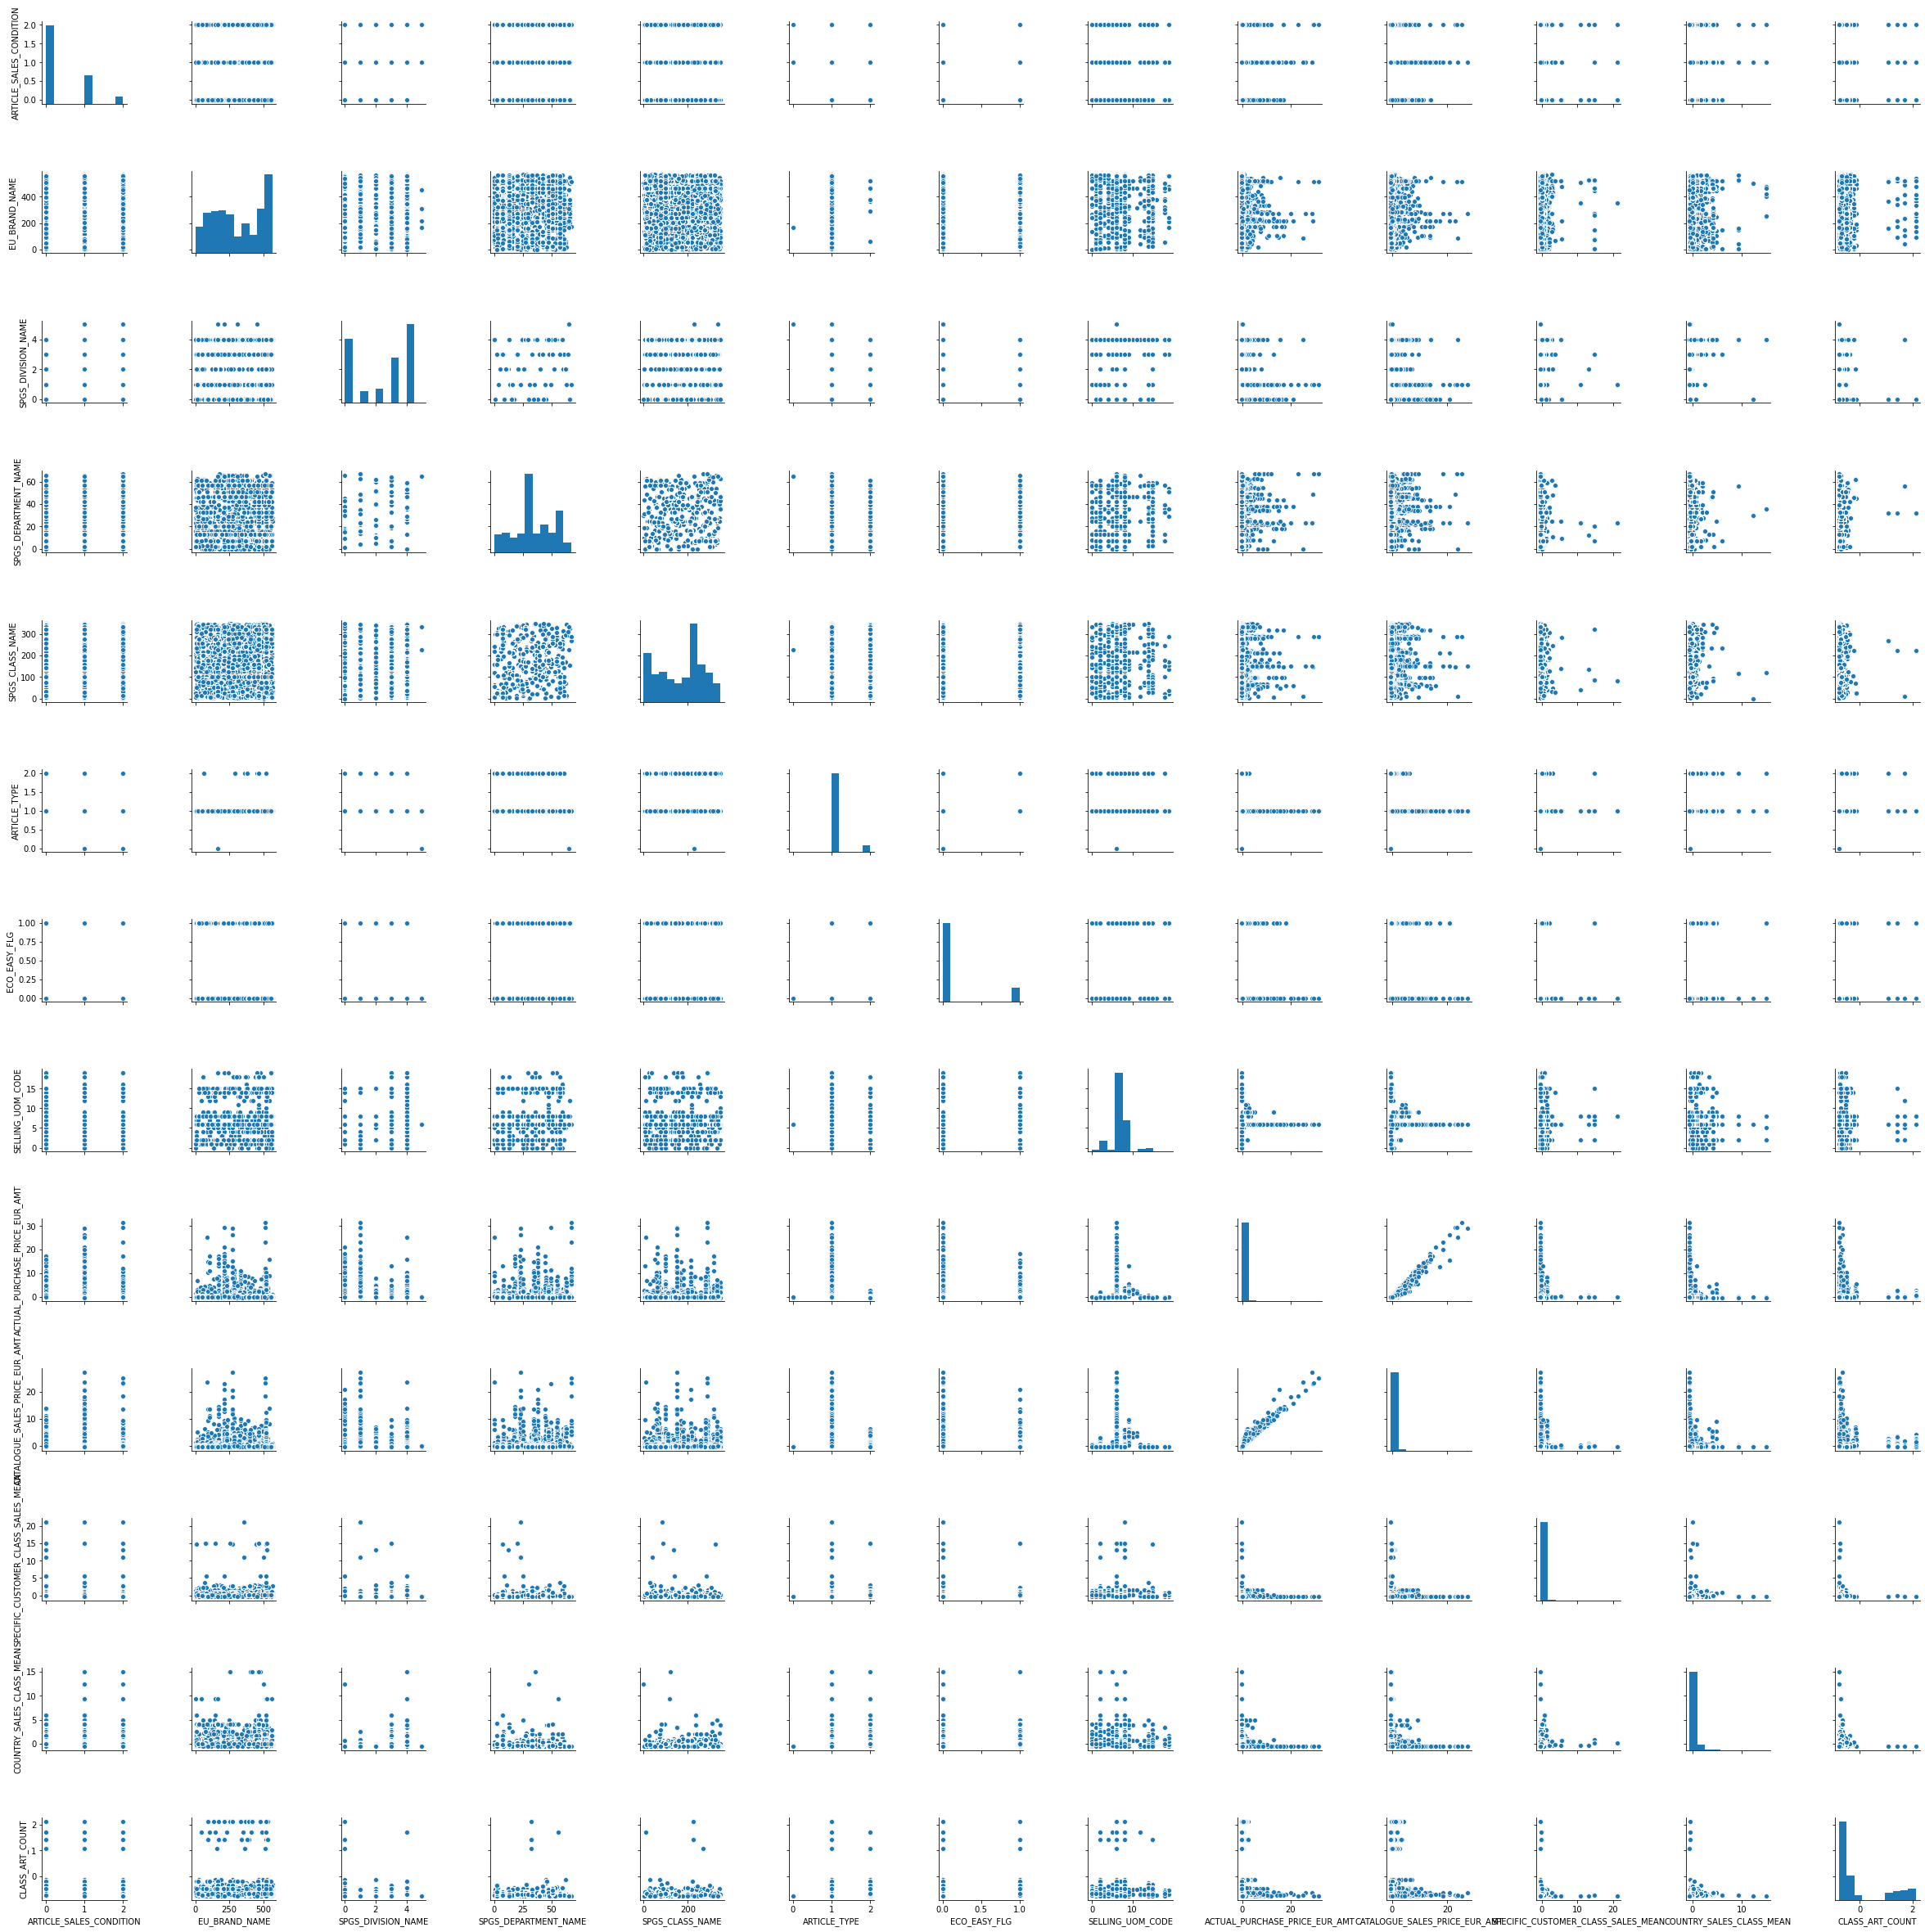

In [37]:
# Wizualizacja korelacji liniowej Spearmana przy pomocy seaborn pairplot.
sns.pairplot(article_data_labled)
plt.show()

In [41]:
# Tworzę model regresji liniowej.
import sklearn.linear_model
mnk = sklearn.linear_model.LinearRegression()

In [42]:
# Uczę model.
mnk.fit(X,y)

LinearRegression()

In [43]:
mnk.intercept_

0.073683039078345

In [44]:
mnk.coef_

array([ 1.31232235e-04, -3.87645319e-02,  8.50367855e-04, -4.43990394e-06,
        2.69606939e-01,  3.86247963e-02,  3.70029984e-03,  1.90689600e-01,
       -1.48866965e-01, -3.85671745e-02, -3.81678694e-02, -1.79170226e-01])

In [45]:
x_nowy = X.mean().values.reshape(1,-1)+0.001
x_nowy

array([[3.08516619e+02, 2.28880952e+00, 3.45682381e+01, 1.70708810e+02,
        1.07942857e+00, 1.50333333e-01, 6.42952381e+00, 1.00000000e-03,
        1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03]])

In [46]:
X.mean().values.reshape(1,-1)

array([[ 3.08515619e+02,  2.28780952e+00,  3.45672381e+01,
         1.70707810e+02,  1.07842857e+00,  1.49333333e-01,
         6.42852381e+00, -3.96716762e-16,  2.26529625e-15,
         7.85447369e-15,  2.69559454e-14,  2.05710528e-14]])

In [47]:
mnk.predict(x_nowy)

array([0.37448863])

In [52]:
# Ocena jakości modelu
# porównanie wartości dopasowanych, obliczonych za pomocą modelu z wartościami oryginalnymi
y_pred = mnk.predict(X)
y_pred[0:10]

array([0.00953284, 0.01121505, 0.01191218, 0.00887959, 0.00736602,
       0.01716995, 0.01372316, 0.01475973, 0.01716995, 0.01716995])

In [53]:
y[0:10]

0    0
1    2
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: ARTICLE_SALES_CONDITION, dtype: int32

In [54]:
#współczynnik determinacji R2
mnk.score(X,y)

0.1112641117849017

In [55]:
sklearn.metrics.r2_score(y, y_pred)

0.1112641117849017

In [56]:
# MSE
sklearn.metrics.mean_squared_error(y, y_pred)

0.32269018864119764

In [57]:
# MAE
sklearn.metrics.mean_absolute_error(y, y_pred)

0.45655590541755925

In [58]:
# MedAE
sklearn.metrics.median_absolute_error(y, y_pred)

0.40876298432558417

In [59]:
# Dzielę zbiór na próbę uczącą i testową.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=12345)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16800, 12)
(4200, 12)
(16800,)
(4200,)


In [60]:
# Tworzę funkcję, która dopasowuje model regresji liniowej do danej próby
# oraz oblicza miary błędów dopasowania.
def fit_regression(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2 = sklearn.metrics.r2_score
    mse = sklearn.metrics.mean_squared_error
    mae = sklearn.metrics.mean_absolute_error
    medae = sklearn.metrics.median_absolute_error
    
    return {
        "r_score_u": r2(y_train, y_train_pred),
        "r_score_t": r2(y_test, y_test_pred),
        "MSE_u": mse(y_train, y_train_pred),
        "MSE_t": mse(y_test, y_test_pred),
        "MAE_u": mae(y_train, y_train_pred),
        "MAE_t": mae(y_test, y_test_pred),
        "MEDAE_u": medae(y_train, y_train_pred),
        "MEDAE_t": medae(y_test, y_test_pred)
        
    }

In [61]:
# Przedstawiam działanie powyższej funkcji oraz jej wyniki.
models = ["Reg. liniowa"]
res = [fit_regression(sklearn.linear_model.LinearRegression(), X_train, X_test, y_train, y_test)]
df_results_errors = pd.DataFrame(res, index=models)

In [63]:
# Wyświetlam tabelę wyników.
df_results_errors

,r_score_u,r_score_t,MSE_u,MSE_t,MAE_u,MAE_t,MEDAE_u,MEDAE_t
Reg. liniowa,0.111851,0.108176,0.321596,0.327346,0.456013,0.458036,0.408516,0.406243


In [64]:
# Tworzę model drzewa decyzyjnego.
from sklearn import tree
model_tree = sklearn.tree.DecisionTreeClassifier()

In [65]:
# Uczę model na zbiorze. (Ze względu na specyfikę zbioru, uczę na całym zbiorze)
model_tree.fit(X, y)

DecisionTreeClassifier()

In [66]:
# Sprawdzam trafność modelu na zbiorzu trningowym.
model_tree.score(X, y)

0.9553809523809523

In [67]:
# Testuję model na zbiorze testowym.
y_model_tree_prediction = model_tree.predict(X_test)
print(y_model_tree_prediction)

[1 1 2 ... 0 0 0]


In [68]:
# Sprawdzam trafność modelu na podstawie przeprowadzonej predykcji.
print("Trafność modelu to: ", sklearn.metrics.accuracy_score(y_test,y_model_tree_prediction)*100, "%")

Trafność modelu to:  95.26190476190476 %


In [69]:
# Wizualizuję drzewo w formie tekstowej. 
print(tree.export_text(model_tree))

|--- feature_9 <= -0.43
|   |--- feature_10 <= -0.55
|   |   |--- class: 2
|   |--- feature_10 >  -0.55
|   |   |--- feature_7 <= -0.22
|   |   |   |--- feature_11 <= -0.76
|   |   |   |   |--- feature_11 <= -0.79
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_11 >  -0.79
|   |   |   |   |   |--- feature_0 <= 454.00
|   |   |   |   |   |   |--- feature_1 <= 2.50
|   |   |   |   |   |   |   |--- feature_7 <= -0.23
|   |   |   |   |   |   |   |   |--- feature_2 <= 42.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- feature_2 >  42.50
|   |   |   |   |   |   |   |   |   |--- feature_7 <= -0.26
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- feature_7 >  -0.26
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_7 >  -0.23
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_1 >  2.50
|   |   |   |   |   |   |   |---

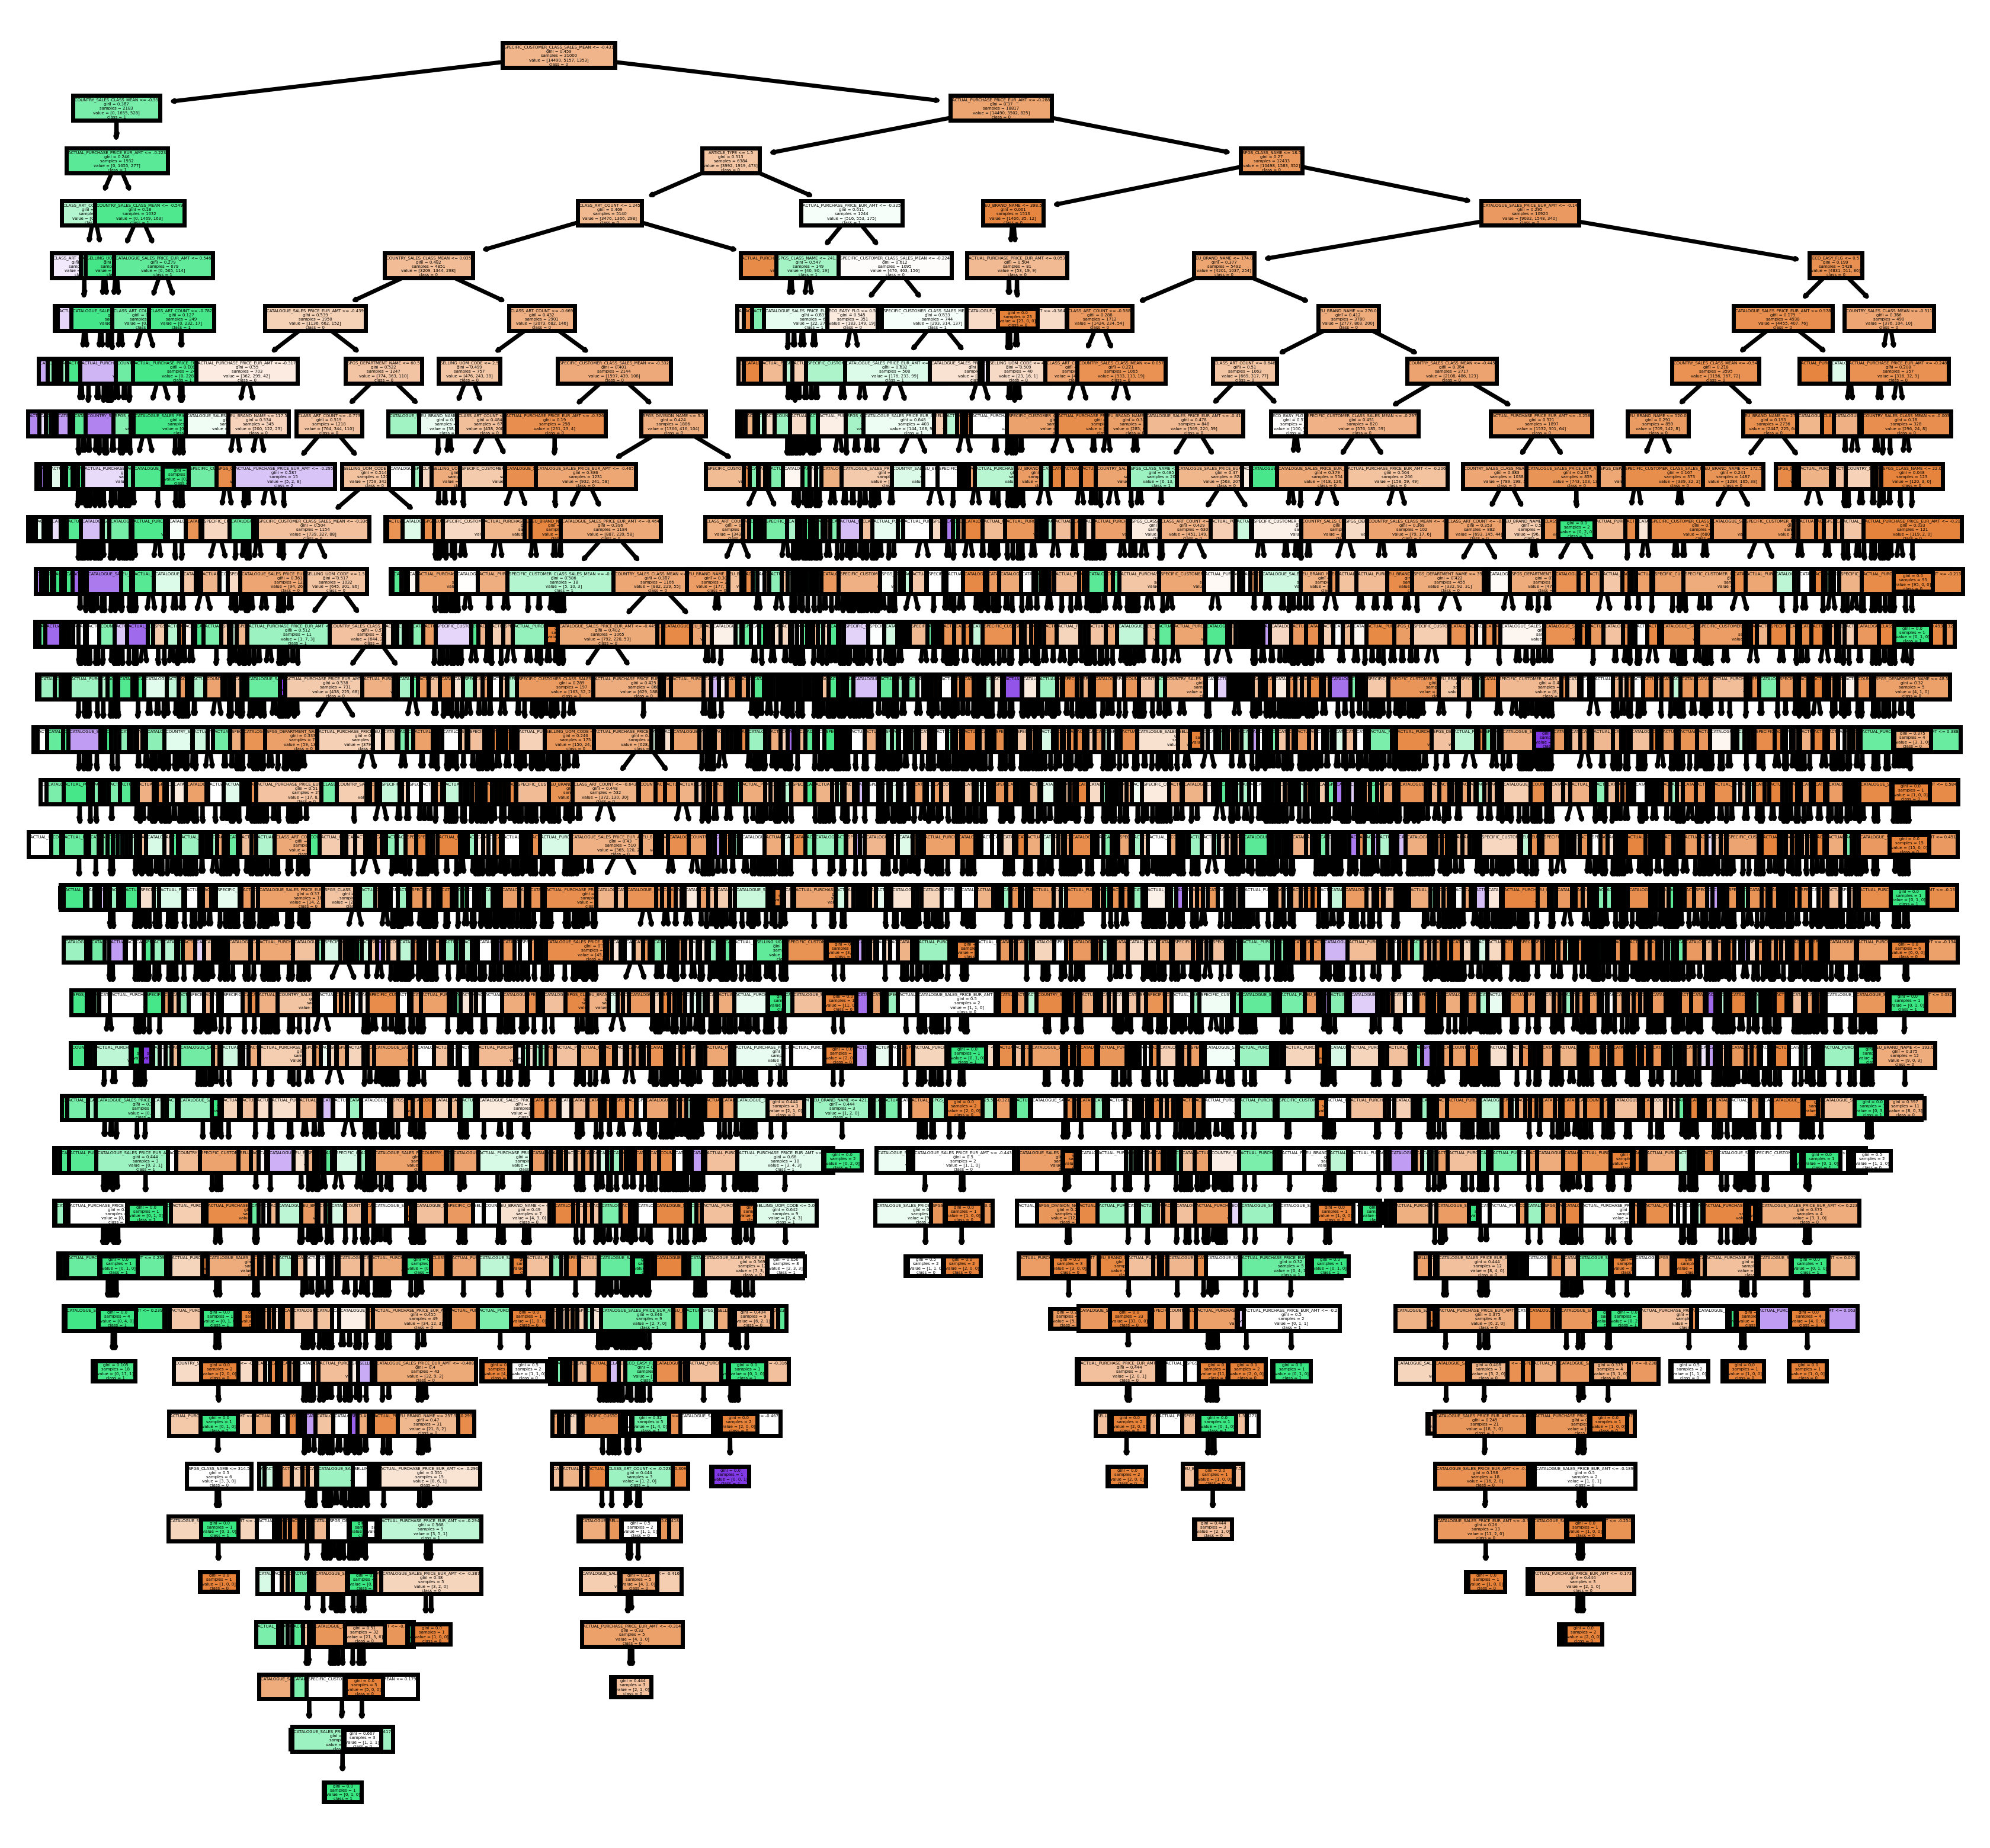

In [70]:
# Wizualizuję drzewo. (figsize = (8,8), dpi=500 są wysokie, aby zapewnić choć minimalną widoczność liści tak dużego drzewa)
fn=['EU_BRAND_NAME', 'SPGS_DIVISION_NAME','SPGS_DEPARTMENT_NAME',
                                    'SPGS_CLASS_NAME', 'ARTICLE_TYPE','ECO_EASY_FLG', 'SELLING_UOM_CODE', 'ACTUAL_PURCHASE_PRICE_EUR_AMT',
                                    'CATALOGUE_SALES_PRICE_EUR_AMT','SPECIFIC_CUSTOMER_CLASS_SALES_MEAN',
                                    'COUNTRY_SALES_CLASS_MEAN','CLASS_ART_COUNT']
cn=['0', '1', '2']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=500)

tree.plot_tree(model_tree,
           feature_names = fn, 
           class_names=cn,
           filled = True);


In [104]:
# Tworzę las losowy
import sklearn.ensemble
model_random_forest = sklearn.ensemble.RandomForestClassifier(random_state=123)

In [105]:
# Uczę model na zbiorze. (Ze względu na specyfikę zbioru, uczę na całym zbiorze)
model_random_forest.fit(X, y)

RandomForestClassifier(random_state=123)

In [106]:
# Sprawdzam trafność modelu na zbiorzu trningowym.
model_random_forest.score(X, y)

0.9553809523809523

In [107]:
# Testuję model na zbiorze testowym.
y_model_random_forest_prediction = model_random_forest.predict(X_test)
print(model_random_forest)

RandomForestClassifier(random_state=123)


In [108]:
# Sprawdzam trafność modelu na podstawie przeprowadzonej predykcji.
print("Trafność modelu to: ", sklearn.metrics.accuracy_score(y_test,y_model_random_forest_prediction)*100, "%")

Trafność modelu to:  95.38095238095238 %


In [71]:
# Podsumowanie:
# Ze względu na specyfikę planowanego modelu z góry zakładałem wykorzystanie modelu bazującego na 
# drzewie decyzyjnym lub lasach losowych. Oba modele zapewniają trafność na poziomie 95% z lekką przewagą lasów losowych.
# Jednak ze względu na fakt, że do nauki modelu posłużył mi cały zbiór, modelem preferowanym przeze mnie będzie ten oparty
# na lasach losowych ze względu na fakt iż poprawiają tendencję drzew decyzyjnych do nadmiernego dopasowywania się
# do zestawu treningowego.
# ( Model regresjii liniowej został dołączony do projektu w ramach ćwiczenia i nie stanowił de facto obiektu badań.)